In [1]:
from src.datasets.city import City
from torch.utils.data import DataLoader
import torch
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
from src.train.utils import load_ckp
from torch import optim

In [2]:
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1

train_set = City(data_dir, split='train', is_transform=True)
val_set = City(data_dir, split='val', is_transform=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True,
                        drop_last=True)

Found 2975 train images
Found 500 val images


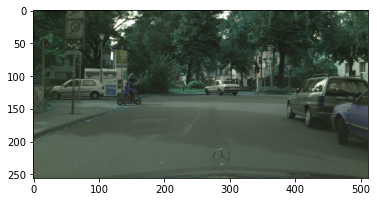

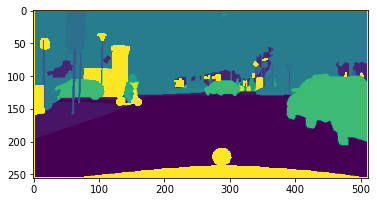

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SmallAxialUNetLBC(3, 19, 10).to(device=device)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)

checkpoint_path = '/home/dsola/repos/PGA-Net/checkpoints/distinctive_snowflake_167_small_axial_lbc_city/epoch11-net-optimizer.pth'

model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
model.eval()
out = nn.Softmax(dim=1)

batch = val_set[3]

img = batch['image']
mask = batch['mask']

plt.figure()
plt.imshow(img.permute(1,2,0).detach().numpy());

plt.figure()
plt.imshow(mask.numpy(), vmin=0, vmax=19);

In [13]:
img = batch['image'].to(device=device).unsqueeze(0)
mask = batch['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

with torch.no_grad():
    output = model(img)

In [14]:
sftmx = out(output)
argmx = torch.argmax(sftmx, dim=1)

In [15]:
print(output.shape)
print(sftmx.shape)
print(argmx.shape)

torch.Size([1, 19, 256, 512])
torch.Size([1, 19, 256, 512])
torch.Size([1, 256, 512])


In [16]:
m = mask.squeeze(0)
a = argmx.squeeze(0)
m = m.detach().cpu().numpy()
a = a.detach().cpu().numpy()

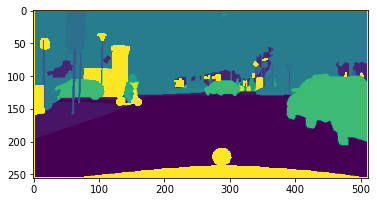

In [17]:
fig, ax = plt.subplots()
ax.imshow(m, vmin=0, vmax=19)

In [18]:
np.unique(m)

array([  0,   1,   2,   5,   6,   7,   8,   9,  10,  11,  12,  13,  18,
       255])

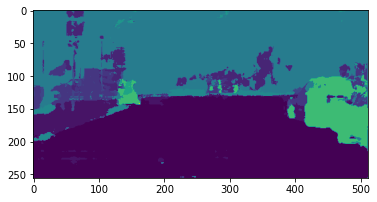

In [19]:
fig, ax = plt.subplots()
ax.imshow(a, vmin=0, vmax=19)

In [39]:
np.unique(a)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 18])

In [40]:
mask.shape

torch.Size([1, 256, 512])

In [45]:
mask1 = mask.detach().clone()

In [54]:
masks = torch.stack([mask, mask1], dim=0)

In [55]:
masks.shape

torch.Size([2, 1, 256, 512])

In [41]:
hist = _fast_hist(mask.to(dtype=torch.long), argmx.to(dtype=torch.long), 19)

In [42]:
per_class_pixel_accuracy(hist)

(tensor(0.4473),
 tensor([0.9992, 0.9176, 0.9635, 0.0000, 0.0231, 0.3520, 0.1650, 0.6175, 0.9491,
         0.8756, 0.8080, 0.8544, 0.0000, 0.9728, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]))

In [43]:
jaccard_index(hist)

(tensor(0.3988),
 tensor([0.9879, 0.8855, 0.8242, 0.0000, 0.0207, 0.3020, 0.1619, 0.1817, 0.9317,
         0.7651, 0.7995, 0.8010, 0.0000, 0.9152, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]))

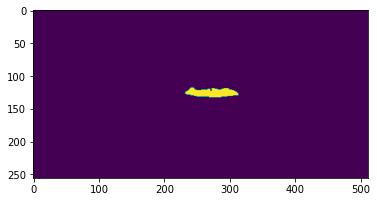

In [177]:
plt.imshow(m==9)

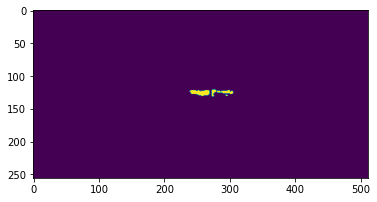

In [178]:
plt.imshow(a==9)